In [221]:
import os
import matplotlib.pyplot as plt
%pylab inline
import numpy as np
from lasagne.layers import DenseLayer
from lasagne.layers import InputLayer
from lasagne.layers import DropoutLayer
from lasagne.layers import Conv2DLayer
from lasagne.layers import MaxPool2DLayer
from lasagne.nonlinearities import softmax
from lasagne.updates import adam
from lasagne.layers import get_all_params
from nolearn.lasagne import NeuralNet
from nolearn.lasagne import TrainSplit
from nolearn.lasagne import objective

Populating the interactive namespace from numpy and matplotlib


Shape of tr_images is:  (2925, 2560)


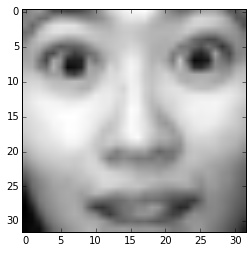

In [244]:
import scipy.io

train = scipy.io.loadmat('filtered_testimg.mat')
train_original = scipy.io.loadmat('labeled_images.mat')

print "Shape of tr_images is: ", train["tr_images"].shape
# (x, y, n_images) = train["tr_images"].shape
(n_images, dim) = train["tr_images"].shape
y = train_original["tr_labels"].ravel()-1

# train_img = np.reshape(np.swapaxes(train["tr_images"], 0, 2), (n_images, x * y))
X = np.reshape(train['tr_images'], (n_images, 1, dim, 1))
y = np.array(y).astype(np.int32)
X = np.array(X).astype(np.float32)
# Normalization
#X -= X.mean()
#X /= X.std()

plt.imshow(np.swapaxes((np.swapaxes(train_original["tr_images"], 0, 2)), 1,2)[0], cmap=pylab.gray())
plt.show()

In [277]:
layers0 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 128, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    # the output layer
    (DenseLayer, {'num_units': 7, 'nonlinearity': softmax}),
]

layers1 = [
    # layer dealing with the input data
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    # first stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 48, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 48, 'filter_size': 3}),
    (Conv2DLayer, {'num_filters': 48, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # second stage of our convolutional layers
    (Conv2DLayer, {'num_filters': 64, 'filter_size': 5}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': 3}),
    (MaxPool2DLayer, {'pool_size': 2}),

    # two dense layers with dropout
    (DenseLayer, {'num_units': 32}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 32}),

    # the output layer
    (DenseLayer, {'num_units': 7, 'nonlinearity': softmax}),
]

layers2 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),

    (Conv2DLayer, {'num_filters': 32, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (Conv2DLayer, {'num_filters': 96, 'filter_size': (3, 3)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),

    (DenseLayer, {'num_units': 64}),
    (DropoutLayer, {}),
    (DenseLayer, {'num_units': 64}),

    (DenseLayer, {'num_units': 7, 'nonlinearity': softmax}),
]

layers3 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),
    (Conv2DLayer, {'num_filters': 96, 'filter_size': (5, 5)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),
    (Conv2DLayer, {'num_filters': 64, 'filter_size': (5, 5)}),
    (MaxPool2DLayer, {'pool_size': (2, 2)}),
    (DenseLayer, {'num_units': 64}),
    (DenseLayer, {'num_units': 7, 'nonlinearity': softmax}),
]

layers4 = [
    (InputLayer, {'shape': (None, X.shape[1], X.shape[2], X.shape[3])}),
    #(Conv2DLayer, {'num_filters': 96, 'filter_size': (5, 5)}),
    #(MaxPool2DLayer, {'pool_size': (2, 2)}),
    (DenseLayer, {'num_units': 42}),
    (DenseLayer, {'num_units': 42}),
    (DenseLayer, {'num_units': 7, 'nonlinearity': softmax}),
]

In [278]:
def regularization_objective(layers, lambda1=0., lambda2=0., *args, **kwargs):
    # default loss
    losses = objective(layers, *args, **kwargs)
    # get the layers' weights, but only those that should be regularized
    # (i.e. not the biases)
    weights = get_all_params(layers[-1], regularizable=True)
    # sum of absolute weights for L1
    sum_abs_weights = sum([abs(w).sum() for w in weights])
    # sum of squared weights for L2
    sum_squared_weights = sum([(w ** 2).sum() for w in weights])
    # add weights to regular loss
    losses += lambda1 * sum_abs_weights + lambda2 * sum_squared_weights
    return losses

In [279]:
net0 = NeuralNet(
    layers=layers0,
    max_epochs=20,

    update=adam,
    update_learning_rate=0.0002,

    objective=regularization_objective,
    objective_lambda2=0.0025,

    train_split=TrainSplit(eval_size=0.25),
    verbose=4,
)
net1 = NeuralNet(
    layers=layers4,
    max_epochs=200,
    update=adam,
    update_learning_rate=0.0001,
    objective=regularization_objective,
    objective_lambda2=0.009,
    train_split=TrainSplit(eval_size=0.25),
    verbose=3,
)

In [280]:
net1.fit(X, y)

# Neural Network with 109669 learnable parameters

## Layer information

  #  name    size
---  ------  --------
  0  input0  1x2560x1
  1  dense1  42
  2  dense2  42
  3  dense3  7

  epoch    train loss    valid loss    train/val    valid acc  dur
-------  ------------  ------------  -----------  -----------  -----
      1       3.42169       3.14458      1.08812      0.24139  0.15s
      2       2.96744       2.97270      0.99823      0.35247  0.13s
      3       2.78424       2.81325      0.98969      0.43274  0.13s
      4       2.60242       2.69959      0.96401      0.46620  0.15s
      5       2.47304       2.61736      0.94486      0.49230  0.13s
      6       2.36450       2.56331      0.92244      0.49971  0.13s
      7       2.27019       2.50831      0.90507      0.52105  0.14s
      8       2.19707       2.46444      0.89151      0.53628  0.14s
      9       2.13226       2.42398      0.87965      0.55326  0.13s
     10       2.07865       2.38982      0.86980      0.5658

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x1077bf150>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x1077bf0d0>,
     custom_score=None,
     layers=[(<class 'lasagne.layers.input.InputLayer'>, {'shape': (None, 1, 2560, 1)}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 42}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 42}), (<class 'lasagne.layers.dense.DenseLayer'>, {'num_units': 7, 'nonlinearity': <function softmax at 0x1073529b0>})],
     loss=None, max_epochs=200, more_params={},
     objective=<function regularization_objective at 0x127ae3848>,
     objective_lambda2=0.009,
     objective_loss_function=<function categorical_crossentropy at 0x1074af758>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x114b61830>],
     on_training_finished=[],
     on_training_started=[<nolearn.lasagne.handlers.PrintLayerInfo instanc

In [255]:
net1.save_params_to ('NN_model_with_preprocess')

In [256]:
def classify_pub_test(classifier):
    '''
    test = scipy.io.loadmat('public_test_images.mat')
    print test
    print test["public_test_images"].shape
    (x, y, n_images) = test["public_test_images"].shape
    test_img = np.reshape(np.swapaxes(test["public_test_images"], 0, 2), (n_images, 1, x, y))
    
    test_img = np.array(test_img).astype(np.float32)
    test_img -= test_img.mean()
    test_img /= test_img.std()
    '''
    test = scipy.io.loadmat('public_test_filtered_no_normalization.mat')
    pub_test = scipy.io.loadmat('./public_test_filtered_no_normalization.mat')
    hid_test = scipy.io.loadmat('./hidden_test_images_filtered.mat')
    (n_images, dim) = pub_test["public_test_images"].shape
    test_img = np.reshape(pub_test['public_test_images'], (n_images, 1, dim, 1))
    test_img = np.array(test_img).astype(np.float32)
    #test_img -= test_img.mean()
    #test_img /= test_img.std()
    pub_res = list(classifier.predict(test_img)+1)
    
    (n_images, dim) = hid_test["hidden_img"].shape
    test_img = np.reshape(hid_test["hidden_img"], (n_images, 1, dim, 1))
    test_img = np.array(test_img).astype(np.float32)
    #test_img -= test_img.mean()
    #test_img /= test_img.std()
    hid_res = list(classifier.predict(test_img)+1)
    return pub_res+hid_res

In [257]:
classify_result = classify_pub_test(net1)
cls_res_list = list(classify_result)
print cls_res_list
with open('submit_nn_sing_layer_90_units_100iter_non_normalized.csv', 'w') as f:
    f.write('Id,Prediction\n')
    index = 1
    for pred in cls_res_list:
        f.write('%d,%d\n'%(index, pred))
        index += 1
    while index<=1253:
        f.write('%d,0\n'%(index))
        index+=1

[7, 7, 4, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 4, 7, 1, 4, 7, 4, 7, 7, 7, 7, 4, 7, 4, 7, 4, 4, 4, 2, 5, 7, 2, 1, 5, 2, 2, 2, 2, 2, 5, 7, 2, 1, 7, 4, 7, 7, 6, 7, 4, 7, 7, 7, 7, 7, 7, 7, 6, 7, 4, 6, 6, 7, 7, 3, 7, 7, 6, 7, 7, 4, 7, 6, 7, 1, 5, 7, 4, 4, 2, 7, 4, 2, 2, 3, 7, 4, 4, 4, 3, 3, 1, 1, 1, 6, 6, 6, 1, 6, 6, 6, 6, 6, 6, 6, 6, 1, 2, 4, 7, 1, 6, 3, 1, 2, 4, 7, 5, 6, 6, 1, 5, 4, 5, 6, 2, 1, 1, 4, 7, 6, 5, 2, 2, 4, 7, 5, 6, 3, 1, 2, 4, 7, 5, 6, 3, 2, 2, 4, 5, 6, 3, 5, 4, 7, 5, 3, 3, 1, 1, 4, 7, 5, 6, 6, 1, 2, 4, 7, 1, 6, 3, 1, 2, 4, 7, 5, 6, 6, 5, 2, 4, 7, 6, 1, 2, 4, 7, 7, 3, 1, 2, 4, 7, 5, 6, 3, 2, 2, 4, 7, 5, 6, 3, 2, 2, 4, 7, 5, 6, 4, 4, 5, 3, 3, 1, 4, 7, 5, 6, 7, 7, 4, 5, 3, 7, 1, 4, 5, 7, 2, 7, 7, 4, 5, 3, 2, 5, 1, 4, 5, 3, 2, 7, 7, 1, 1, 1, 1, 6, 7, 7, 7, 7, 7, 7, 7, 5, 2, 2, 2, 5, 1, 3, 3, 3, 3, 6, 6, 3, 4, 4, 3, 4, 4, 4, 4, 4, 4, 4, 4, 3, 7, 7, 7, 7, 7, 5, 3, 5, 5, 5, 5, 5, 5, 6, 6, 3, 6, 1, 1, 1, 1, 1, 1, 1, 2, 1, 2, 1, 7, 7, 7, 7, 7, 7, 7, 7, 4, 4, 7, 7, 2, 2, 2, 2, 2, 1, 

<module 'matplotlib.pyplot' from '/Users/zexuanwang/anaconda/lib/python2.7/site-packages/matplotlib/pyplot.pyc'>

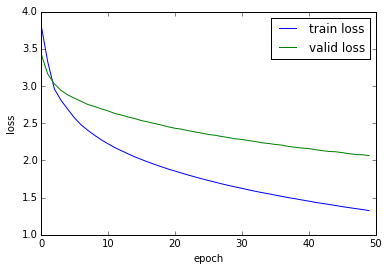

In [258]:
from nolearn.lasagne.visualize import plot_loss
from nolearn.lasagne.visualize import plot_conv_weights
from nolearn.lasagne.visualize import plot_conv_activity
from nolearn.lasagne.visualize import plot_occlusion
plot_loss(net1)
#plot_conv_activity(net1.layers_[1], X[0:1])